# 17b: High-Risk vs Low-Risk Enrichment Analysis

**Goal**: Identify which dominoes are over/under-represented in high σ(V) hands.

**Key Questions**:
1. Which dominoes are enriched in high-risk hands?
2. Which dominoes are associated with predictable outcomes?
3. Are these effects statistically significant?

In [1]:
# === CONFIGURATION ===
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"

# === Setup imports ===
import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests

from forge.analysis.utils import viz
from forge.oracle import schema
from forge.oracle.rng import deal_from_seed

viz.setup_notebook_style()
print("Ready")

Ready


## 1. Load and Prepare Data

In [2]:
# Load unified features
features_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/12b_unified_features.csv"
df = pd.read_csv(features_path)

# Reconstruct hands
hands_data = []
for _, row in df.iterrows():
    seed = int(row['base_seed'])
    hands = deal_from_seed(seed)
    p0_hand = set(hands[0])
    hands_data.append({
        'seed': seed,
        'hand': p0_hand,
        'V_std': row['V_std'],
        'V_mean': row['V_mean'],
    })

print(f"Loaded {len(hands_data)} hands")
print(f"σ(V) range: [{df['V_std'].min():.1f}, {df['V_std'].max():.1f}]")

Loaded 200 hands
σ(V) range: [0.0, 37.7]


In [3]:
# Split into high-risk (top 25% σ(V)) and low-risk (bottom 25% σ(V))
sigma_values = [h['V_std'] for h in hands_data]
q75 = np.percentile(sigma_values, 75)
q25 = np.percentile(sigma_values, 25)

high_risk = [h for h in hands_data if h['V_std'] >= q75]
low_risk = [h for h in hands_data if h['V_std'] <= q25]

print(f"Q75 (high-risk threshold): σ(V) >= {q75:.1f}")
print(f"Q25 (low-risk threshold): σ(V) <= {q25:.1f}")
print(f"High-risk (top 25%): {len(high_risk)} hands")
print(f"Low-risk (bottom 25%): {len(low_risk)} hands")

Q75 (high-risk threshold): σ(V) >= 21.2
Q25 (low-risk threshold): σ(V) <= 7.9
High-risk (top 25%): 50 hands
Low-risk (bottom 25%): 50 hands


In [4]:
# Create domino name mapping
def domino_name(d_id: int) -> str:
    pips = schema.domino_pips(d_id)
    return f"{pips[0]}-{pips[1]}"

DOMINO_NAMES = [domino_name(d) for d in range(28)]

## 2. Fisher's Exact Test for Risk Enrichment

In [5]:
results = []

for d in range(28):
    # Count presence in high-risk vs low-risk
    high_with = sum(1 for h in high_risk if d in h['hand'])
    high_without = len(high_risk) - high_with
    low_with = sum(1 for h in low_risk if d in h['hand'])
    low_without = len(low_risk) - low_with
    
    # 2x2 contingency table
    table = [[high_with, low_with],
             [high_without, low_without]]
    
    # Fisher's exact test
    odds_ratio, p_value = fisher_exact(table)
    
    # Enrichment ratio
    freq_high = high_with / len(high_risk) if len(high_risk) > 0 else 0
    freq_low = low_with / len(low_risk) if len(low_risk) > 0 else 0
    enrichment = (freq_high / freq_low) if freq_low > 0 else float('inf')
    log2_enrichment = np.log2(enrichment) if enrichment > 0 and enrichment != float('inf') else 0
    
    results.append({
        'domino': DOMINO_NAMES[d],
        'd_id': d,
        'high_with': high_with,
        'low_with': low_with,
        'freq_high': freq_high,
        'freq_low': freq_low,
        'odds_ratio': odds_ratio,
        'log2_enrichment': log2_enrichment,
        'p_value': p_value,
    })

results_df = pd.DataFrame(results)

In [6]:
# Apply BH FDR correction
reject, p_adj, _, _ = multipletests(results_df['p_value'], alpha=0.05, method='fdr_bh')
results_df['p_adjusted'] = p_adj
results_df['significant'] = reject

# Sort by enrichment (high-risk / low-risk)
results_df = results_df.sort_values('log2_enrichment', ascending=False)

print("Top 10 Enriched in High-Risk Hands:")
print(results_df.head(10)[['domino', 'freq_high', 'freq_low', 'log2_enrichment', 'p_value', 'p_adjusted', 'significant']].to_string(index=False))

print("\n\nTop 10 Enriched in Low-Risk Hands (Depleted in High-Risk):")
print(results_df.tail(10)[['domino', 'freq_high', 'freq_low', 'log2_enrichment', 'p_value', 'p_adjusted', 'significant']].to_string(index=False))

Top 10 Enriched in High-Risk Hands:
domino  freq_high  freq_low  log2_enrichment  p_value  p_adjusted  significant
   6-5       0.34      0.08         2.087463 0.002607    0.028486         True
   3-1       0.26      0.12         1.115477 0.124737    0.503672        False
   6-0       0.38      0.18         1.078003 0.043961    0.246184        False
   4-2       0.38      0.22         0.788496 0.125918    0.503672        False
   6-3       0.24      0.14         0.777608 0.307989    0.957762        False
   4-1       0.30      0.18         0.736966 0.241424    0.844983        False
   2-2       0.32      0.24         0.415037 0.504479    1.000000        False
   5-2       0.24      0.18         0.415037 0.624155    1.000000        False
   6-4       0.24      0.20         0.263034 0.809699    1.000000        False
   4-3       0.28      0.24         0.222392 0.819996    1.000000        False


Top 10 Enriched in Low-Risk Hands (Depleted in High-Risk):
domino  freq_high  freq_low  log2_

In [7]:
# Summary
n_significant = results_df['significant'].sum()
print(f"\nSignificant at FDR < 0.05: {n_significant} dominoes")


Significant at FDR < 0.05: 3 dominoes


## 3. Volcano Plot

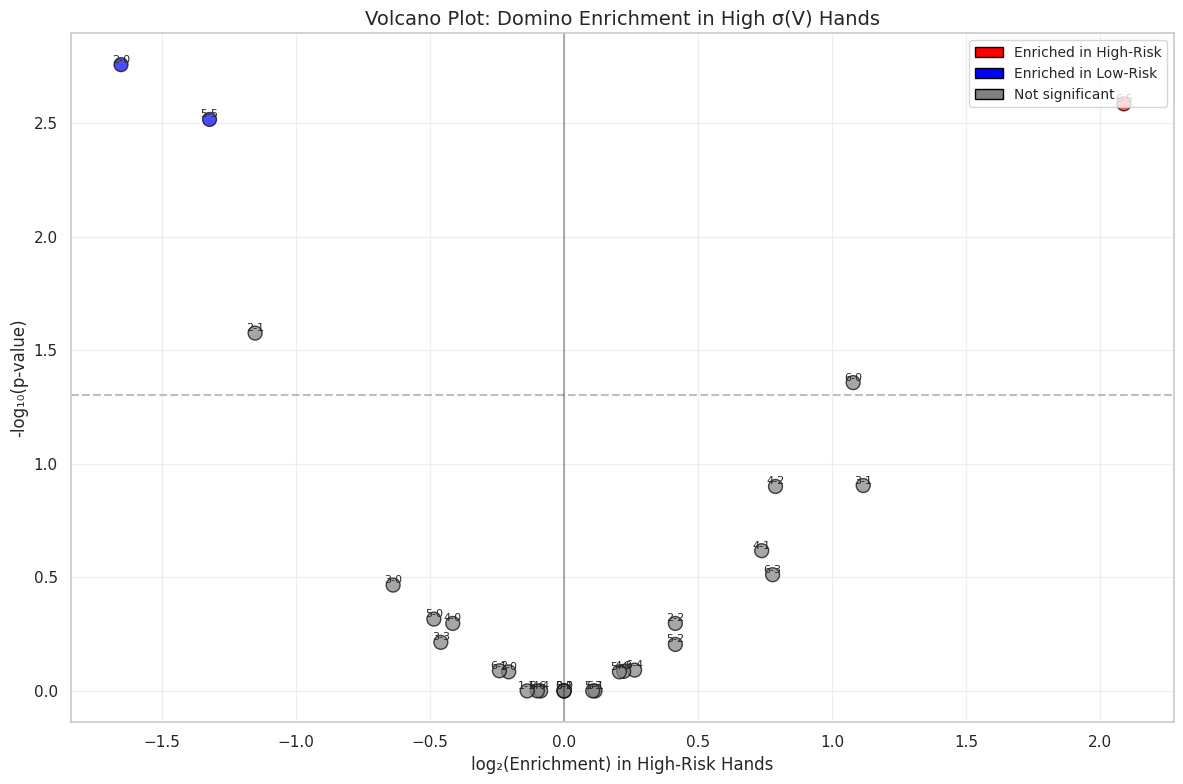

In [8]:
fig, ax = plt.subplots(figsize=(12, 8))

results_df['neg_log10_p'] = -np.log10(results_df['p_value'].clip(lower=1e-10))

# Color by significance
colors = []
for _, row in results_df.iterrows():
    if row['significant'] and row['log2_enrichment'] > 0:
        colors.append('red')  # High-risk enriched
    elif row['significant'] and row['log2_enrichment'] < 0:
        colors.append('blue')  # Low-risk enriched
    else:
        colors.append('gray')

ax.scatter(results_df['log2_enrichment'], results_df['neg_log10_p'], 
           c=colors, s=100, alpha=0.7, edgecolors='black')

for _, row in results_df.iterrows():
    ax.annotate(row['domino'], (row['log2_enrichment'], row['neg_log10_p']), 
                fontsize=8, ha='center', va='bottom')

ax.axhline(-np.log10(0.05), color='gray', linestyle='--', alpha=0.5, label='p = 0.05')
ax.axvline(0, color='black', linestyle='-', alpha=0.3)

ax.set_xlabel('log₂(Enrichment) in High-Risk Hands', fontsize=12)
ax.set_ylabel('-log₁₀(p-value)', fontsize=12)
ax.set_title('Volcano Plot: Domino Enrichment in High σ(V) Hands', fontsize=14)

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='red', edgecolor='black', label='Enriched in High-Risk'),
    Patch(facecolor='blue', edgecolor='black', label='Enriched in Low-Risk'),
    Patch(facecolor='gray', edgecolor='black', label='Not significant'),
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=10)

plt.tight_layout()
plt.savefig('../../results/figures/17b_risk_volcano.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Comparison with E[V] Enrichment

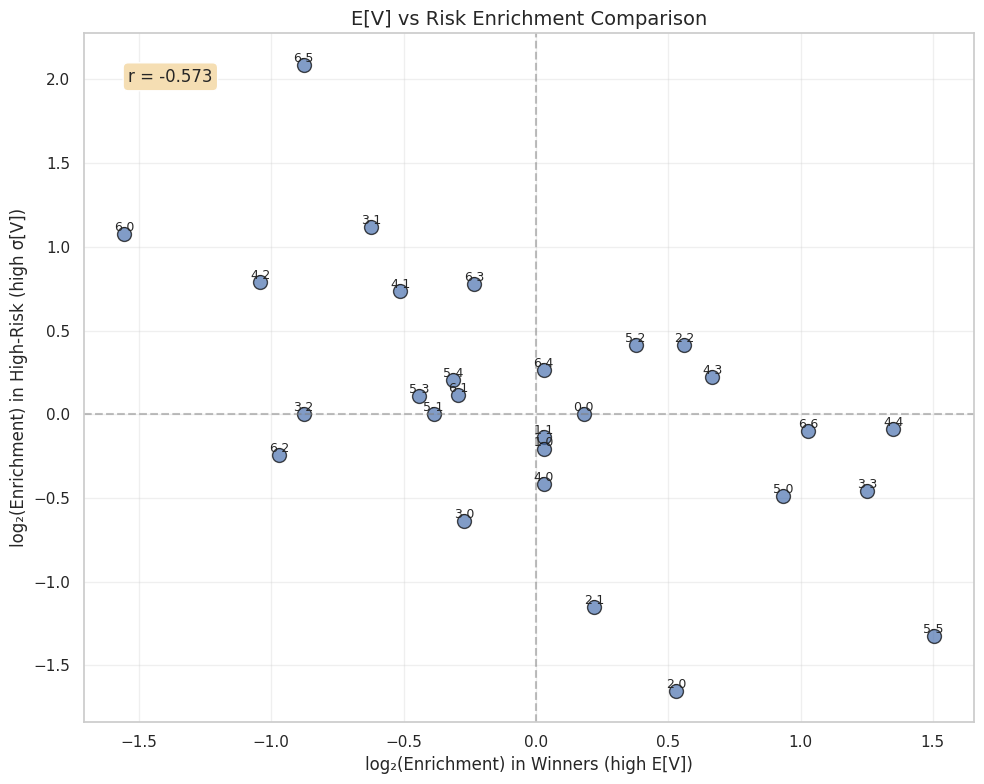

In [9]:
# Load E[V] enrichment results for comparison
ev_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/17a_enrichment.csv"
ev_df = pd.read_csv(ev_path)

# Merge
comparison = pd.merge(
    results_df[['domino', 'log2_enrichment', 'p_adjusted']].rename(
        columns={'log2_enrichment': 'risk_log2', 'p_adjusted': 'risk_p'}),
    ev_df[['domino', 'log2_enrichment', 'p_adjusted']].rename(
        columns={'log2_enrichment': 'ev_log2', 'p_adjusted': 'ev_p'}),
    on='domino'
)

# Scatter plot of risk vs EV enrichment
fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(comparison['ev_log2'], comparison['risk_log2'], s=100, alpha=0.7, edgecolors='black')

for _, row in comparison.iterrows():
    ax.annotate(row['domino'], (row['ev_log2'], row['risk_log2']), fontsize=9, ha='center', va='bottom')

ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax.axvline(0, color='gray', linestyle='--', alpha=0.5)

# Add correlation
corr = np.corrcoef(comparison['ev_log2'], comparison['risk_log2'])[0, 1]
ax.text(0.05, 0.95, f'r = {corr:.3f}', transform=ax.transAxes, fontsize=12, 
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat'))

ax.set_xlabel('log₂(Enrichment) in Winners (high E[V])', fontsize=12)
ax.set_ylabel('log₂(Enrichment) in High-Risk (high σ[V])', fontsize=12)
ax.set_title('E[V] vs Risk Enrichment Comparison', fontsize=14)

plt.tight_layout()
plt.savefig('../../results/figures/17b_ev_vs_risk.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Save Results

In [10]:
# Save full results
output_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/17b_risk_enrichment.csv"
results_df.to_csv(output_path, index=False)
print(f"Saved to {output_path}")

# Save comparison
comp_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/17b_ev_risk_comparison.csv"
comparison.to_csv(comp_path, index=False)
print(f"Saved comparison to {comp_path}")

Saved to /home/jason/v2/mk5-tailwind/forge/analysis/results/tables/17b_risk_enrichment.csv
Saved comparison to /home/jason/v2/mk5-tailwind/forge/analysis/results/tables/17b_ev_risk_comparison.csv


## Key Findings

### Risk Enrichment

Which dominoes appear more often in high-variance hands?

### E[V] vs Risk Relationship

The correlation between E[V] enrichment and risk enrichment reveals whether good dominoes are also predictable.

### Interpretation

Based on the inverse E[V]-σ(V) correlation (r = -0.38):
- Dominoes enriched in winners should be DEPLETED in high-risk
- This reflects the "good hands are safer" finding

### Files Generated

- `results/tables/17b_risk_enrichment.csv` - Risk enrichment results
- `results/tables/17b_ev_risk_comparison.csv` - Comparison with E[V] enrichment
- `results/figures/17b_risk_volcano.png` - Volcano plot
- `results/figures/17b_ev_vs_risk.png` - E[V] vs risk scatter